<h1> Python Data Notebook (Template) </h1>
<h3> Preserve this template, duplicate this file before using it!!</h3>
<strong> Author: Micah Simmerman, Nolan Ollada, Nathan Palmer </strong>

<strong>Resource URL:</strong>

<strong>Database file(s), columnar dataset(s), etc.:</strong>

# Project Description
This project will investigate data mining techniques for efficient isolation of principle classes hidden inside massive datasets (i.e., those containing millions of data points or more). This project will identify a series of robust and sequential data mining techniques that can be used to extract, clean, normalize, and prepare the data for causal analysis. Our investigation will use Principal Component Analysis (PCA) and apriori-based Data Cube techniques to observe temporal and regional trends in automotive safety. We will use the insight derived from these Data Cubes to identify and predict the principal driver classes composing the SWITRS California Collision Data Set using Decision Tree Classification (DTC), Frequent Pattern Mining (FPM), and Bayesian Belief Networks (BBN). The project will conclude with a k-fold cross validation or/or cluster based data discovery  to estimate the accuracy and usefulness of each model.

In [116]:
# Libraries and packages
import os
import sqlite3
import pandas as pd
pd.__version__
import numpy as np
# from sklearn import datasets  # contains the iris data set, among other things.
from sklearn import decomposition, datasets
from sklearn.decomposition import PCA  # Super important for sklearn PCA
from sklearn.preprocessing import MinMaxScaler # For normalization
from sklearn.preprocessing import StandardScaler
from scipy import stats
from collections import Counter
import math
import seaborn as sns
import matplotlib.pyplot as plt

# SQLite db file connection is achieved in the try/except statements below. 
# TODO: add sections to read-in mySQL/PostGreSQL and csv files.

tables = []  # GLOBAL TABLE INDEX
attribute_list = []  # GLOBAL ATTRIBUTE INDEX

# NOTE: always store the switrs.sqlite file in the parent directory where this python notebook is kept.
db_file = '../switrs.sqlite'  # name the db file downloaded directly from https://www.kaggle.com/datasets/alexgude/california-traffic-collision-data-from-switrs
sqliteConnection = sqlite3.connect(db_file)

# if os.path.isfile(db_file):  # determine if there is any SQLite db file by that name exists in the specified file location.
sqliteConnection = sqlite3.connect(db_file)  # establish a connection if the file does exist.
cursor = sqliteConnection.cursor()  # create a cursor object.
table_query = 'SELECT name from sqlite_master where type= "table"'
cursor.execute(table_query)
result = cursor.fetchall()
print()
print(len(result), "tables found.")
for i in range(len(result)):
    tables.append(result[i][0])
    # print(result[i][0])

# the second part of the algorithm extracts the attributes of each table identified in the first step and places them into a 2D list. 
for table in tables:
    consumer_complaints_count_records = "PRAGMA table_info("
    consumer_complaints_count_records += str(table)  + ");"  # build the sqlite query string using the current list object
    cursor.execute(consumer_complaints_count_records)  # execute the query string
    result = cursor.fetchall()  # collect the results
    temp_list = []
    for item in result:
        temp_list.append(item[1])
    attribute_list.append(temp_list)  # export the list attribute table after it is built
    # print("The", table, "table contains", result[0][0], "data points")  # print the results
    # print()
print("Table and attribute name extraction completed successfully.")


print('DB file and Dependencies Loaded.')  
# else:
#     print(os.path.isfile(db_file), "No SQLite file detected.")  # otherwise, print the connection status.


4 tables found.
Table and attribute name extraction completed successfully.
DB file and Dependencies Loaded.


Start by collecting information about the table names in the database.

In [117]:
# Now we have a list of tables and their respective attribute columns.
print("Tables in the database: ", tables)
print("Attribute list: ", attribute_list)

Tables in the database:  ['case_ids', 'collisions', 'victims', 'parties']
Attribute list:  [['case_id', 'db_year'], ['case_id', 'population', 'county_city_location', 'county_location', 'primary_road', 'secondary_road', 'distance', 'direction', 'intersection', 'weather_1', 'weather_2', 'location_type', 'ramp_intersection', 'tow_away', 'collision_severity', 'killed_victims', 'injured_victims', 'party_count', 'primary_collision_factor', 'pcf_violation_code', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'pedestrian_action', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 'truck_collision', 'not_private_property', 'alcohol_involved', 'statewide_vehicle_type_at_fault', 'chp_vehicle_type_at_fault', 'severe_injury_count', 'other_visible_injury_count', 'complaint_of_pain_injury_count', 'pedestrian_killed_count', 'pedestrian_injured_count', 'bicyclist_killed_count', 'bicyclist_

## Data Cleaning and Preprocessing
run the code below to remove the attributes in the remove_cols_collisions and remove_cols_parties tables specified. You can run the above 2 code blocks again to see that the specified attributes were removed.

Running the following cell twice currently results in an error. 

    RATIONAL FOR ATTRIBUTE COLUMN REMOVAL:
    collisions.officer_id: responding officers identification is not relevant to the factors of a collision.
    collisions.chp_shift: chp_shift indicates the work shift period of the responding officer. More accurate temporal measurements exist.
    collisions.special_condition: 
    collisions.beat_type: 
    collisions.city_division_lapd: 
    collisions.chp_beat_class: 
    collisions.beat_number: 
    collisions.pcf_violation: 
    collisions.pcf_violation_subsection: 
    collisions.hit_and_run: 
    collisions.process_date: 

    For a complete list of attribute definitions, please visit: https://peteraldhous.com/Data/ca_traffic/SWITRS_codebook.pdf

# Warning:
The following cell block removes unwanted attribute columns from the SWITRS database file and will take a long time to execute. Repeated requests should not impose any harm on the database file. Time to complete last session = 14 minutes. 

In [9]:
# Increase the page count and turn off SQLite Journaling Mode to reduce the overhead of the SQLite ALTER TABLE statements.
increase_page_count = "PRAGMA max_page_count = 2147483646;"
turn_off_journal = "PRAGMA journal_mode=OFF"
cursor.execute(increase_page_count)
cursor.execute(turn_off_journal)  # turn off the journaling mode (temporarily) to avoid exceeding local disk space limitations.
sqliteConnection.commit()

In [10]:
# PLACE AN INDEX ON 'case_id' IN ALL THREE TABLES TO FACILITATE DRILL-THROUGH QUERIES. 
try:
    set_case_id_index_collisions = "CREATE INDEX collisions_case_id ON collisions(case_id);"
    set_case_id_index_parties = "CREATE INDEX parties_case_id ON parties(case_id);"
    set_case_id_index_victims = "CREATE INDEX victims_case_id ON victims(case_id);"
    cursor.execute(set_case_id_index_collisions)
    cursor.execute(set_case_id_index_parties)
    cursor.execute(set_case_id_index_victims)
    sqliteConnection.commit()
except:
    print("SWITRS DB file contains the following indices...") 
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("collisions table index 'collisions_case_id' created on 'case_id' attribute column.") 
    print("parties table index 'parties_case_id' created on 'case_id' attribute column.")
    print("victims table index 'victims_case_id' created on 'case_id' attribute column.")

In [11]:
# Include the attribute columns you wish to remove in the list(s) below.
remove_cols_collisions = ["side_of_highway", "road_condition_2", "primary_ramp", "secondary_ramp", "jurisdiction", "chp_beat_type", "reporting_district", "state_highway_indicator", "caltrans_county", "caltrans_district", "state_route", "route_suffix", "postmile_prefix", "postmile", "chp_road_type", "officer_id", "chp_shift", "special_condition", "beat_type", "city_division_lapd", "chp_beat_class", "beat_number", "pcf_violation", "pcf_violation_subsection", "hit_and_run", "process_date"]
remove_cols_parties = ["hazardous_materials", "oaf_violation_code"]
# Alternatively, we can identify the attribute ids with a string and concatenate it into a SQLite query statement.
# remove_cols_collisions = "officer_id, chp_shift, special_condition, beat_type, city_division_lapd, chp_beat_class, beat_number, pcf_violation, pcf_violation_subsection, hit_and_run, process_date"
# remove_cols_parties = "hazardous_materials, oaf_violation_code"

try:
    for col in remove_cols_collisions:
        drop_collisions_columns = "ALTER TABLE collisions DROP  "
        drop_collisions_columns += col  + ";" 
        cursor.execute(drop_collisions_columns)
        sqliteConnection.commit()
        print("Removed", col, "from the 'collisions' table.")
        print("working...")
    for attrib in remove_cols_parties:
        drop_parties_columns = "ALTER TABLE parties DROP "
        drop_parties_columns += attrib  + ";" 
        cursor.execute(drop_parties_columns)
        sqliteConnection.commit()
        print("Removed", attrib, "from the 'parties' table")
        print("working...")
    print("The identified attribute columns successfully removed from the switrs database file.")
    print("Overwrite ../switrs.sqlite with a newly decompressed switrs source file to reverse these changes")
except:
    print("These columns have been removed already.")

## CODE FOR RESTORING JOURNAL MODE (DEFAULT = OFF)
# turn_journal_on = "PRAGMA journal_mode=ON"  # let's leave this off for now. 
# cursor.execute(turn_journal_on)  # turn the journaling mode back on so we can roll-back our changes.
# sqliteConnection.commit()  # commit the change to the database file.
# print("journal mode is back on.")

Removed side_of_highway from the 'collisions' table.
working...
Removed road_condition_2 from the 'collisions' table.
working...
Removed primary_ramp from the 'collisions' table.
working...
Removed secondary_ramp from the 'collisions' table.
working...
Removed jurisdiction from the 'collisions' table.
working...
Removed chp_beat_type from the 'collisions' table.
working...
Removed reporting_district from the 'collisions' table.
working...
Removed state_highway_indicator from the 'collisions' table.
working...
Removed caltrans_county from the 'collisions' table.
working...
Removed caltrans_district from the 'collisions' table.
working...
Removed state_route from the 'collisions' table.
working...
Removed route_suffix from the 'collisions' table.
working...
Removed postmile_prefix from the 'collisions' table.
working...
Removed postmile from the 'collisions' table.
working...
Removed chp_road_type from the 'collisions' table.
working...
These columns have been removed already.


In [118]:
# Now we have a list of tables and their respective attribute columns.+
for i in range(len(tables)):
    print(tables[i], "has attributes:", attribute_list[i])
    # print(attribute_list[i])
    

case_ids has attributes: ['case_id', 'db_year']
collisions has attributes: ['case_id', 'population', 'county_city_location', 'county_location', 'primary_road', 'secondary_road', 'distance', 'direction', 'intersection', 'weather_1', 'weather_2', 'location_type', 'ramp_intersection', 'tow_away', 'collision_severity', 'killed_victims', 'injured_victims', 'party_count', 'primary_collision_factor', 'pcf_violation_code', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'pedestrian_action', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 'truck_collision', 'not_private_property', 'alcohol_involved', 'statewide_vehicle_type_at_fault', 'chp_vehicle_type_at_fault', 'severe_injury_count', 'other_visible_injury_count', 'complaint_of_pain_injury_count', 'pedestrian_killed_count', 'pedestrian_injured_count', 'bicyclist_killed_count', 'bicyclist_injured_count', 'motorcyclist_killed_coun

In [119]:
# ENUMERATE DATA POINTS
data_point_count = 0
for table in range(len(tables)):
    count_records = 'SELECT COUNT(*) FROM ('  # start the string.
    count_records += tables[table] + ");"  # concatenate the variable and complete the string build.
    cursor.execute(count_records)  # 
    result = cursor.fetchall()
    data_point_count += result[0][0]
    print("The", tables[table], "table contains", result[0][0], "data points.")

print("Current number of data points accross tables of 'switrs.sqlite' database file =", data_point_count)

The case_ids table contains 9424334 data points.
The collisions table contains 9424334 data points.
The victims table contains 9639334 data points.
The parties table contains 18669166 data points.
Current number of data points accross tables of 'switrs.sqlite' database file = 47157168


### Training/Test Set Generation Using Random Data Point Sampling

Below, we create a Pandas DataFrame by pulling 10,000 samples at random from the switrs collisions table. We then extract these case_id's into a python list and use it to execute a set-based SQLite query to pull in the points from the other database tables. Doing this dramatically increases the performance of these queries. The representative data extracted from these columns is then used for data cleaning, nominal attribute quantification, and the application of normalizing functions (such as z-score) on numerical attribute columns to support common PCA libraries such as sklearn.

Note that the code blocks below can be used to triangulate on data points based on the multiple attributes you can examine in each representative dataframe. As an exmaple, suppose you wish to locate victims of a car accident who were fully-ejected from their vehicle as a result of failure to fasten a safety belt. To locate such an object, one might perform the following queries on the 'victims_matching_10000_training_df' data frame to examine a representative sample collected at random from the 'victims' switrs.sqlite database file. The following queries may be used to locate such a datapoint within the set. 

    # TAKE A LOOK AT A SPECIFIC COLUMN(S)
    print("BEGIN: Examine victims_matching_10000_training_df.loc[:,'victim_safety_equipment_2']")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(victims_matching_10000_training_df.loc[:,"victim_safety_equipment_2"])
    print()
    print("BEGIN: Examine victims_matching_10000_training_df.loc[:,'victim_ejected']")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(victims_matching_10000_training_df.loc[:,"victim_ejected"])

The code within this block populates the case_id list object with the case_id values collected in the random sample procedure. This list is then used to perform a set selection using a "SELECT FROM WHERE case_id IN ..." type SQLite query construction. The nature of set queries and generation of the index on the 'case_id' attribute column of each table makes this a very speedy query set. 

####  Generating the n=10,000 Training Sets (PANDAS data frames) Using Random Sampling w/o Replacement

The following code sections produce three (n=10,000) random sample dataframes, composed of matching data points from the 'collisions', 'parties', and 'victims' tables by using a 'case_id' sampling index, kept in the form of a python list 'n_10000_training_set_case_ids' in the cell below.

In [120]:
# Create a python list of the 'case_id' values for the n=10,000 random sample set that we are about to generate.
n_10000_training_set_case_ids = []  # this list will contain each 'case_id'

# The estimated completion time is 20.5 seconds.
print("Generating a n=10,000 random-sample training set from the 'collisions' table of the switrs.sqlite database file...")
print("#####################################################################################################")
# Read 10000 random samples from the collisions table into a local pandas DataFrame. (BOOTSTRAP SAMPLING)
collisions_n_10000_training_set_df = pd.read_sql_query("SELECT * FROM collisions ORDER BY RANDOM() LIMIT 10000;", sqliteConnection)
# sort the data frame in ascending order of case_id
collisions_n_10000_training_set_df.sort_values(by=['case_id'], ascending=True, kind='quicksort', na_position='last', ignore_index=False, key=None)# sort the df in row ascending order of case_id

print()
print("collisions_random_10000_df.head()...")
print(collisions_n_10000_training_set_df.head())
print(collisions_n_10000_training_set_df['case_id'].values[0])

# populate the case_ids list
for i in collisions_n_10000_training_set_df.index:
    n_10000_training_set_case_ids.append(collisions_n_10000_training_set_df['case_id'].values[i])

# Check our progress.
print("SAMPLE 'n_10000_training_set_case_ids':")
print(n_10000_training_set_case_ids)  # USE THIS LIST TO CALL THE DATA OBJECTS IN FROM THE OTHER TABLES (I.e., 'parties' and 'victims'). 

Generating a n=10,000 random-sample training set from the 'collisions' table of the switrs.sqlite database file...
#####################################################################################################

collisions_random_10000_df.head()...
   case_id        population county_city_location county_location  \
0  3650671           >250000                 1942     los angeles   
1  0919704  100000 to 250000                 4807          solano   
2  4838861   50000 to 100000                 3016          orange   
3  4987307    unincorporated                 4400      santa cruz   
4  1244641  100000 to 250000                 1920     los angeles   

      primary_road secondary_road  distance direction  intersection weather_1  \
0           RT 110       TUNNEL 3      50.0     south           0.0   raining   
1      MAGAZINE ST         5TH ST       0.0      None           1.0     clear   
2  ORANGETHORPE AV        KRAEMER      86.0      west           0.0     clear   
3    L

In [121]:
# Estimated cell runtime = 0.5 seconds
## This cell runs lightning fast (approximately 4 seconds) because of its' set-based query and the index placed on case_id in each table.
## Here, we are building a tuple-formatted string containing the case_id's we are interested in collecting from switrs. We close the argument at the end of the paragraph.
training_set_case_ids = "("  # we will close this when we append the other argument strings.
for i in n_10000_training_set_case_ids:  # scan through the training set case_id's.
    training_set_case_ids += i  # append each case_id we find to the sql query string.
    training_set_case_ids += ", "  # delete this substring before closing the string.
training_set_case_ids = training_set_case_ids[:-2]  # 
training_set_case_ids += ") ORDER BY case_id DESC;"

# Complete each of the sql queries
parties_query = "SELECT * FROM parties WHERE case_id IN " + training_set_case_ids
victims_query = "SELECT * FROM victims WHERE case_id IN " + training_set_case_ids

# PULL IN THE CORRESPONDING RECORDS FROM 'parties' and 'victims' TABLES
parties_matching_10000_training_df = pd.read_sql_query(parties_query, sqliteConnection)
victims_matching_10000_training_df = pd.read_sql_query(victims_query, sqliteConnection)

# Check our work
print("Generating a n=10,000 random-sample training set from the 'parties' table of the switrs.sqlite database file...")
print("#######################################################")
print(".head() view of the 'parties_matching_10000_training_df' dataframe object:")
print(parties_matching_10000_training_df.head())
print("END")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print()
print("Generating a n=10,000 random-sample training set from the 'victims' table of the switrs.sqlite database file...")
print("#######################################################")
print(".head() view of the 'victims_matching_10000_training_df' dataframe object:")
print(victims_matching_10000_training_df.head())
print("END")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print()

Generating a n=10,000 random-sample training set from the 'parties' table of the switrs.sqlite database file...
#######################################################
.head() view of the 'parties_matching_10000_training_df' dataframe object:
         id  case_id  party_number  party_type  at_fault party_sex  party_age  \
0  10490684  9268304             2  pedestrian         0    female       24.0   
1  10490683  9268304             1      driver         1      None        NaN   
2  10490086  9267956             2      driver         0      None        NaN   
3  10490085  9267956             1      driver         1      male       65.0   
4  10489407  9267048             2      driver         0      male       48.0   

          party_sobriety party_drug_physical direction_of_travel  ...  \
0  had not been drinking                None                east  ...   
1     impairment unknown                   G               south  ...   
2         not applicable      not applicable       

###  Generating the n=10,000 Test Sets (PANDAS data frames) using Random Sampling w/o Replacement

Next, we will generate another series of n=10,000 dataframes that we will use to evalutate the assumptions of our models with. To enforce random sampling without replacement, we will exlcude samples in 'case_ids' from consideration in the SQLite query.

In [122]:
# Approximate time to complete this cell = 24 seconds.
n_10000_test_set_case_ids = []  # similar to 'training_case_ids'

# 
print("Generating an N=10,000 random point test set, composed of collisions table data objects from the switrs.sqlite database file.")
print("Working...")

# Build a tuple formatted string that contains the case_id's we are interested in and leave out those we are not.
case_ids_not_in_test_set = "("  # we will close this when we append the other argument strings.
for i in n_10000_training_set_case_ids:  # append every case_id included in the training set. 
    case_ids_not_in_test_set += i  # append it to the tuple formatted sql string argument.
    case_ids_not_in_test_set += ", "  # delete this substring before closing the string.
case_ids_not_in_test_set = case_ids_not_in_test_set[:-2]  # cut off the last two chars.
case_ids_not_in_test_set += ") ORDER BY RANDOM() LIMIT 10000;"  # complete the sqlite statement.

# This sql query demonstrates the logic behind the "random sampling without replacement" scheme. 
collisions_test_set_query = "SELECT * FROM collisions WHERE case_id NOT IN " + case_ids_not_in_test_set  # exclude training set members

# Use the sql query response to populate the 'collisions_n_10000_test_set_df' data frame object.
collisions_n_10000_test_set_df = pd.read_sql_query(collisions_test_set_query, sqliteConnection)
collisions_n_10000_test_set_df.sort_values(by=['case_id'], ascending=True, kind='quicksort', na_position='last', ignore_index=False, key=None)# sort the df in ascending order of case_id

# Check our work
print("(n=10,000) data frame formed with randomly selected 'collisions' table test tuples. These case id's compose the test set.")
print("#######################################################")
print(".head() view of the 'parties_matching_10000_df' test set dataframe object:")
print(collisions_n_10000_test_set_df.head())

# populate the 'test_case_ids' list
for i in collisions_n_10000_test_set_df.index:
    n_10000_test_set_case_ids.append(collisions_n_10000_test_set_df['case_id'].values[i])
    
print("collisions_n_10000_test_set_df.head()...")
print(collisions_n_10000_test_set_df.head())

print(n_10000_test_set_case_ids)

Generating an N=10,000 random point test set, composed of collisions table data objects from the switrs.sqlite database file.
Working...
(n=10,000) data frame formed with randomly selected 'collisions' table test tuples. These case id's compose the test set.
#######################################################
.head() view of the 'parties_matching_10000_df' test set dataframe object:
    case_id      population county_city_location county_location  \
0   4208084  unincorporated                 4100       san mateo   
1  90931751         >250000                 1942     los angeles   
2   4024911  unincorporated                 3300       riverside   
3  91118077  unincorporated                 3300       riverside   
4   8582751         >250000                 1942     los angeles   

                    primary_road  secondary_road  distance direction  \
0           ALAMEDA DELAS PULGAS     WOODSIDE RD      75.0     south   
1  I-405 N/B (SAN DIEGO FREEWAY)  SEPULVEDA BLVD    2640.

In [123]:
# Now we need to build the other two test set data frames.
test_set_case_ids = "("  # we will close this when we append the other argument strings.
for i in n_10000_test_set_case_ids:
    test_set_case_ids += i 
    test_set_case_ids += ", "  # delete this substring before closing the string.
test_set_case_ids = test_set_case_ids[:-2]  # 
test_set_case_ids += ") ORDER BY case_id DESC;"

# Complete each of the sql queries
parties_query = "SELECT * FROM parties WHERE case_id IN " + test_set_case_ids
victims_query = "SELECT * FROM victims WHERE case_id IN " + test_set_case_ids

collisions_n_10000_test_set_df

# PULL IN THE CORRESPONDING RECORDS FROM 'parties' and 'victims' TABLES
parties_matching_n_10000_test_set_df = pd.read_sql_query(parties_query, sqliteConnection)
victims_matching_n_10000_test_set_df = pd.read_sql_query(victims_query, sqliteConnection)

# Check our work
print("(n=10,000) data frame composed of 'parties' table tuples, associated with 'case_id's found in 'collisions_random_10000_df'")
print("#######################################################")
print(".head() view of the 'parties_matching_n_10000_test_set_df' dataframe object:")
print(parties_matching_n_10000_test_set_df.head())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print()
print("(n=10,000) data frame composed of 'victims' table tuples, associated with 'case_id's found in 'collisions_random_10000_df'")
print("#######################################################")
print(".head() view of the 'victims_matching_n_10000_test_set_df' dataframe object:")
print(victims_matching_n_10000_test_set_df.head())

(n=10,000) data frame composed of 'parties' table tuples, associated with 'case_id's found in 'collisions_random_10000_df'
#######################################################
.head() view of the 'parties_matching_n_10000_test_set_df' dataframe object:
         id  case_id  party_number      party_type  at_fault party_sex  \
0  10491352  9268863             2  parked vehicle         0      None   
1  10491351  9268863             1          driver         1      None   
2  10489717  9267712             2          driver         0    female   
3  10489716  9267712             1          driver         1    female   
4  10489503  9267556             2          driver         0      male   

   party_age         party_sobriety party_drug_physical direction_of_travel  \
0        NaN         not applicable      not applicable               north   
1        NaN     impairment unknown                   G               north   
2       26.0  had not been drinking                None       

### Eliminating Irrelevant Attributes

Use the cells below to evaluate the attribute columns of each table to smooth, normalize, and/or mark attribute columns for removal.

#### Examining collisions_n_10000_training_set_df

In [124]:
# TAKE A CLOSE LOOK AT THE collisions_n_10000_training_set_df DATAFRAME OBJECT (COLUMNS MANAGED WITH SQL)
print("BEGIN collisions_n_10000_training_set_df.info()")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(collisions_n_10000_training_set_df.info())
print("END collisions_n_10000_training_set_df.info()")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("BEGIN collisions_n_10000_training_set_df.head()")
print(parties_matching_10000_training_df.head())

# 
print("###################################################################################")
columns = list(collisions_n_10000_training_set_df.columns)
print("List of remaining columns in collisions_n_10000_training_set_df:")
print(columns)


BEGIN collisions_n_10000_training_set_df.info()
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case_id                          10000 non-null  object 
 1   population                       10000 non-null  object 
 2   county_city_location             10000 non-null  object 
 3   county_location                  10000 non-null  object 
 4   primary_road                     10000 non-null  object 
 5   secondary_road                   10000 non-null  object 
 6   distance                         10000 non-null  float64
 7   direction                        7514 non-null   object 
 8   intersection                     9906 non-null   float64
 9   weather_1                        9955 non-null   object 
 10  weather_2  

### Address NULL Collision Values

In [125]:
# Start with Numeric Attributes
numeric_collision_columns = collisions_n_10000_training_set_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_collision_columns:
    print("Column:", col)
    print(collisions_n_10000_training_set_df[col].value_counts())
    print("\n")
# Most of the numeric columns can have 0 filled in for their NaN values. Lets deal with special cases first.

# PARTY COUNT: The most common and intuitive value for this will be 2. 
collisions_n_10000_training_set_df['party_count'] = collisions_n_10000_training_set_df['party_count'].fillna(2)
# For the rest of the columns, it makes most sense to fill NaN with 0. 
# Note: filling Latitude and Longitude with 0 doesnt make much logical sense, but for the sake of avoiding errors when using them for calulations, we will fill with 0.
# If using Lat and Long in the future, consider excluding entries with 0 value.
for col in numeric_collision_columns:
    collisions_n_10000_training_set_df[col] = collisions_n_10000_training_set_df[col].fillna(0)

Column: distance
distance
0.0        2508
100.0       324
200.0       282
300.0       245
528.0       243
           ... 
29568.0       1
371.0         1
897.0         1
567.0         1
1689.0        1
Name: count, Length: 863, dtype: int64


Column: intersection
intersection
0.0    7595
1.0    2311
Name: count, dtype: int64


Column: tow_away
tow_away
1.0    4990
0.0    4930
Name: count, dtype: int64


Column: killed_victims
killed_victims
0.0    9937
1.0      55
2.0       4
4.0       1
Name: count, dtype: int64


Column: injured_victims
injured_victims
0.0    6186
1.0    2659
2.0     800
3.0     223
4.0      80
5.0      34
6.0      11
7.0       3
8.0       1
Name: count, dtype: int64


Column: party_count
party_count
2    6796
1    1835
3    1091
4     218
5      46
6      13
7       1
Name: count, dtype: int64


Column: pedestrian_collision
pedestrian_collision
0    9737
1     263
Name: count, dtype: int64


Column: bicycle_collision
bicycle_collision
0    9708
1     292
Name: count

### Normalize (Numeric) Collision Attributes

In [126]:
# from sklearn import decomposition, datasets  # imported libraries needed for this code.
# from sklearn.preprocessing import StandardScaler  # '''

# Create 
min_max_scaler = MinMaxScaler()  # instantiate a MinMaxScaler() object [applied a min-max vector transform for Numeric PCA]
std_scalar = StandardScaler()  # instantiate a StandardScalar() object [applies a standard vector transform for Numeric PCA]

# APPLY STANDARD AND MIN-MAX NORMALIZATION TO NUMERIC ATTRIBUTE COLUMNS 
X_std = std_scalar.fit_transform(collisions_n_10000_training_set_df[numeric_collision_columns])
X_min_max = min_max_scaler.fit_transform(collisions_n_10000_training_set_df[numeric_collision_columns])

In [127]:
# TAKE A LOOK AT A SPECIFIC COLUMN(S)
print("BEGIN: Examine collisions_n_10000_training_set_df.loc[:,'collision_date']")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(collisions_n_10000_training_set_df.loc[:,"collision_date"])
print()
print("BEGIN: Examine collisions_n_10000_training_set_df.loc[:,'ramp_intersection']")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(collisions_n_10000_training_set_df.loc[:,"ramp_intersection"])

# List of safe columns to drop: [INCLUDE ATTRIBUTE COLUMNS TO DROP HERE] 

BEGIN: Examine collisions_n_10000_training_set_df.loc[:,'collision_date']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0       2008-02-24
1       2003-07-25
2       2010-07-26
3       2010-11-21
4       2004-01-16
           ...    
9995    2016-03-21
9996    2019-08-30
9997    2018-05-10
9998    2018-07-15
9999    2019-11-07
Name: collision_date, Length: 10000, dtype: object

BEGIN: Examine collisions_n_10000_training_set_df.loc[:,'ramp_intersection']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0       None
1       None
2       None
3       None
4       None
        ... 
9995    None
9996    None
9997    None
9998    None
9999    None
Name: ramp_intersection, Length: 10000, dtype: object


#### Examining the 'parties' Table Using 'parties_matching_10000_training_df'

In [128]:
# TAKE A CLOSE LOOK AT THE 'parties_matching_10000_training_df' DATAFRAME OBJECT (COLUMNS MANAGED WITH SQL)
print("BEGIN: Examine 'parties_matching_10000_training_df' df using '.info()'")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(parties_matching_10000_training_df.info())
print("END: parties_matching_10000_training_df.info()")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("BEGIN parties_matching_10000_training_df.head()")
print(parties_matching_10000_training_df.head())

# 
print("###################################################################################")
columns = list(parties_matching_10000_training_df.columns)
print("List of remaining columns in parties_matching_10000_training_df:")
print(columns)

BEGIN: Examine 'parties_matching_10000_training_df' df using '.info()'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17504 entries, 0 to 17503
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            17504 non-null  int64  
 1   case_id                       17504 non-null  object 
 2   party_number                  17504 non-null  int64  
 3   party_type                    17475 non-null  object 
 4   at_fault                      17504 non-null  int64  
 5   party_sex                     15176 non-null  object 
 6   party_age                     14789 non-null  float64
 7   party_sobriety                16974 non-null  object 
 8   party_drug_physical           2804 non-null   object 
 9   direction_of_travel           17022 non-null  object 
 10  party_safety_equipment_

### Address NULL Party Values

In [129]:
# Start with Numeric Attributes
numeric_parties_columns = parties_matching_10000_training_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_parties_columns:
    print("Column:", col)
    print(parties_matching_10000_training_df[col].value_counts())
    print("\n")
# Most of the numeric columns can have 0 filled in for their NaN values. Lets deal with special cases first.
# ID: lets just leave this alone
# PARTY NUMBER: leave this alone
# PARTY AGE: Lets fill with missing values with the mean party age
mean_age = parties_matching_10000_training_df['party_age'].mean()
parties_matching_10000_training_df['party_age'].fillna(mean_age, inplace=True)
# For the rest of the columns, it makes most sense to fill NaN with 0. 
# Note: dont touch ID or PARTY NUMBER as these could create unintentional results and it wont be needed for calculations

# Get all column names except 'id' and 'party_number'
parties_cols_to_fill = [col for col in parties_matching_10000_training_df.columns if col not in ['id', 'party_number']]

# Fill missing values in these columns with 0
parties_matching_10000_training_df[parties_cols_to_fill] = parties_matching_10000_training_df[parties_cols_to_fill].fillna(0)

Column: id
id
2046515    2
507896     2
6456218    2
6386576    2
6000793    2
          ..
5032957    1
5032956    1
5031586    1
5031585    1
1803053    1
Name: count, Length: 17497, dtype: int64


Column: party_number
party_number
1    8802
2    7195
3    1189
4     251
5      52
6      14
7       1
Name: count, dtype: int64


Column: at_fault
at_fault
0    9423
1    8081
Name: count, dtype: int64


Column: party_age
party_age
20.0    463
21.0    428
23.0    427
22.0    427
19.0    424
       ... 
4.0       2
9.0       2
1.0       1
3.0       1
99.0      1
Name: count, Length: 96, dtype: int64


Column: cellphone_in_use
cellphone_in_use
0.0    13039
1.0      244
Name: count, dtype: int64


Column: school_bus_related
school_bus_related
1.0    49
Name: count, dtype: int64


Column: party_number_killed
party_number_killed
0    17445
1       55
2        3
3        1
Name: count, dtype: int64


Column: party_number_injured
party_number_injured
0    13448
1     3406
2      515
3       94


### Normalize Party Attributes

In [130]:
# making df to scale because we want to exclude id and party_number
parties_cols_to_scale = parties_matching_10000_training_df.select_dtypes(include=['float64', 'int64']).columns
parties_cols_to_scale = [col for col in parties_cols_to_scale if col not in ['id', 'party_number']]

scaler = MinMaxScaler()
parties_matching_10000_training_df[parties_cols_to_scale] = scaler.fit_transform(parties_matching_10000_training_df[parties_cols_to_scale])

In [131]:
# TAKE A LOOK AT A SPECIFIC COLUMN(S)
print("BEGIN: Examine parties_matching_10000_training_df.loc[:,'movement_preceding_collision']")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(parties_matching_10000_training_df.loc[:,"movement_preceding_collision"])
print()
print("BEGIN: Examine parties_matching_10000_training_df.loc[:,'cellphone_in_use']")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(parties_matching_10000_training_df.loc[:,"cellphone_in_use"])

# List of safe columns to drop: ["direction_of_travel", "",] 

BEGIN: Examine parties_matching_10000_training_df.loc[:,'movement_preceding_collision']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0        proceeding straight
1        proceeding straight
2                     parked
3              making u-turn
4           slowing/stopping
                ...         
17499       slowing/stopping
17500       slowing/stopping
17501         changing lanes
17502    proceeding straight
17503    proceeding straight
Name: movement_preceding_collision, Length: 17504, dtype: object

BEGIN: Examine parties_matching_10000_training_df.loc[:,'cellphone_in_use']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17499    0.0
17500    0.0
17501    0.0
17502    0.0
17503    1.0
Name: cellphone_in_use, Length: 17504, dtype: float64


#### Examining victims_matching_10000_training_df

In [132]:
# TAKE A CLOSE LOOK AT THE 'victims_matching_10000_training_df' DATAFRAME OBJECT (COLUMNS MANAGED WITH SQL)
print("BEGIN: Examine 'victims_matching_10000_training_df' df using '.info()'")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(victims_matching_10000_training_df.info())
print("END victims_matching_10000_training_df.info()")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("BEGIN victims_matching_10000_training_df.head()")
print(victims_matching_10000_training_df.head())

# 
print("###################################################################################")
columns = list(victims_matching_10000_training_df.columns)
print("List of remaining columns in victims_matching_10000_training_df:")
print(columns)

BEGIN: Examine 'victims_matching_10000_training_df' df using '.info()'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8722 entries, 0 to 8721
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         8722 non-null   int64  
 1   case_id                    8722 non-null   object 
 2   party_number               8722 non-null   int64  
 3   victim_role                8722 non-null   object 
 4   victim_sex                 8504 non-null   object 
 5   victim_age                 8428 non-null   float64
 6   victim_degree_of_injury    8722 non-null   object 
 7   victim_seating_position    8708 non-null   object 
 8   victim_safety_equipment_1  8214 non-null   object 
 9   victim_safety_equipment_2  6898 non-null   object 
 10  victim_ejected             8687 non-null   object 
dtypes: fl

### Address NULL Victim Values

In [133]:
# Start with Numeric Attributes
numeric_victims_columns = victims_matching_10000_training_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_victims_columns:
    print("Column:", col)
    print(victims_matching_10000_training_df[col].value_counts())
    print("\n")

# ID: lets just leave this alone
# VICTIM NUMBER: leave this alone
# VICTIM AGE: Lets fill with missing values with the mean party age
mean_age = victims_matching_10000_training_df['victim_age'].mean()
victims_matching_10000_training_df['victim_age'].fillna(mean_age, inplace=True)
# There are no more numeric attributes
# Note: dont touch ID or PARTY NUMBER as these could create unintentional results and it wont be needed for calculations


Column: id
id
1174897    2
2617689    2
2971357    2
5078835    1
75240      1
          ..
2352104    1
2352105    1
2353192    1
2353193    1
1028652    1
Name: count, Length: 8719, dtype: int64


Column: party_number
party_number
2    4227
1    3921
3     460
4      83
5      23
6       8
Name: count, dtype: int64


Column: victim_age
victim_age
18.0     276
19.0     263
21.0     254
22.0     242
20.0     237
        ... 
90.0       2
92.0       2
94.0       1
101.0      1
96.0       1
Name: count, Length: 97, dtype: int64




### Normalize Victim Attributes

In [134]:
# making df to scale because we want to exclude id and party_number
victim_cols_to_scale = victims_matching_10000_training_df.select_dtypes(include=['float64', 'int64']).columns
victim_cols_to_scale = [col for col in victim_cols_to_scale if col not in ['id', 'party_number']]

scaler = MinMaxScaler()
victims_matching_10000_training_df[victim_cols_to_scale] = scaler.fit_transform(victims_matching_10000_training_df[victim_cols_to_scale])

In [135]:
# TAKE A LOOK AT A SPECIFIC COLUMN(S)
print("BEGIN: Examine victims_matching_10000_training_df.loc[:,'victim_safety_equipment_2']")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(victims_matching_10000_training_df.loc[:,"victim_safety_equipment_2"])
print()
print("BEGIN: Examine victims_matching_10000_training_df.loc[:,'victim_ejected']")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(victims_matching_10000_training_df.loc[:,"victim_ejected"])

# List of safe columns to drop: [INCLUDE ATTRIBUTE COLUMNS TO DROP HERE] 

BEGIN: Examine victims_matching_10000_training_df.loc[:,'victim_safety_equipment_2']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0                                None
1           lap/shoulder harness used
2                                None
3       lap/shoulder harness not used
4           lap/shoulder harness used
                    ...              
8717                             None
8718                             None
8719                             None
8720                             None
8721                             None
Name: victim_safety_equipment_2, Length: 8722, dtype: object

BEGIN: Examine victims_matching_10000_training_df.loc[:,'victim_ejected']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0       not ejected
1       not ejected
2       not ejected
3       not ejected
4       not ejected
           ...     
8717        unknown
8718        unknown
8719        unknown
8720    not ejected
8721    not e

### Examine the resulting attribute outcomes.

In [165]:
# NOMINAL ATTRIBUTES AFTER CLEANING
nominal_collisions_columns = collisions_n_10000_training_set_df.select_dtypes(include=['object']).columns
print("Nominal attributes of the collisions table:")
print(nominal_collisions_columns)
print()
print("Nominal attributes of the parties table:")
nominal_parties_columns = parties_matching_10000_training_df.select_dtypes(include=['object']).columns
print(nominal_parties_columns)
print()
print("Nominal attributes of the victims table:")
nominal_victims_columns = victims_matching_10000_training_df.select_dtypes(include=['object']).columns
print(nominal_victims_columns)
print()

# Examine unique outcomes of 'collisions_n_10000_training_set_df'
print("collisions_n_10000_training_set_df unique nominal attribute outcomes after data cleaning:")
for col in collisions_n_10000_training_set_df[nominal_collisions_columns]:
    print(collisions_n_10000_training_set_df[col].unique())
print()
    
# Examine unique outcomes of 'parties_matching_10000_training_df'
print("parties_matching_10000_training_df unique nominal attribute outcomes after data cleaning:")
for col in parties_matching_10000_training_df[nominal_parties_columns]:
    print(parties_matching_10000_training_df[col].unique())
print()

# Examine unique outcomes of 'victims_matching_10000_training_df'
print("victims_matching_10000_training_df unique nominal attribute outcomes after data cleaning:")
for col in victims_matching_10000_training_df[nominal_victims_columns]:
    print(victims_matching_10000_training_df[col].unique())
print()

Nominal attributes of the collisions table:
Index(['case_id', 'population', 'county_city_location', 'county_location',
       'primary_road', 'secondary_road', 'direction', 'weather_1', 'weather_2',
       'location_type', 'ramp_intersection', 'collision_severity',
       'primary_collision_factor', 'pcf_violation_code',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'pedestrian_action', 'road_surface',
       'road_condition_1', 'lighting', 'control_device',
       'statewide_vehicle_type_at_fault', 'chp_vehicle_type_at_fault',
       'collision_date', 'collision_time'],
      dtype='object')

Nominal attributes of the parties table:
Index(['case_id', 'party_type', 'party_sex', 'party_sobriety',
       'party_drug_physical', 'direction_of_travel',
       'party_safety_equipment_1', 'party_safety_equipment_2',
       'financial_responsibility', 'cellphone_use_type',
       'oaf_violation_category', 'oaf_violation_section',
       'oaf_violat

In [164]:
# NUMERIC ATTRIBUTES AFTER DATA CLEANING
print("collisions_n_10000_training_set_df statistics after data cleaning:")
print(collisions_n_10000_training_set_df[numeric_collision_columns].describe().round(2))  # collisions training set
print()
print("parties_matching_10000_training_df statistics after data cleaning:")
print(parties_matching_10000_training_df[numeric_parties_columns].describe().round(2))  # parties training set
print()
print("victims_matching_10000_training_df statistics after data cleaning:")
print(victims_matching_10000_training_df.describe().round(2))  # victims training set 

collisions_n_10000_training_set_df statistics after data cleaning:
       distance  intersection  tow_away  killed_victims  injured_victims  \
count  10000.00      10000.00   10000.0        10000.00         10000.00   
mean     635.48          0.23       0.5            0.01             0.55   
std     2488.26          0.42       0.5            0.09             0.87   
min        0.00          0.00       0.0            0.00             0.00   
25%        0.00          0.00       0.0            0.00             0.00   
50%      100.00          0.00       0.0            0.00             0.00   
75%      466.00          0.00       1.0            0.00             1.00   
max    93456.00          1.00       1.0            4.00             8.00   

       party_count  pedestrian_collision  bicycle_collision  \
count     10000.00              10000.00           10000.00   
mean          1.99                  0.03               0.03   
std           0.67                  0.16               0.17

In [163]:
# Let's take a look at the categorical column distributions next...
print("statistics on the nominal attributes of the collisions_n_10000_training_set_df data set after cleaning:")
print(collisions_n_10000_training_set_df[nominal_collisions_columns].describe())  # collisions training set
print()
print("statistics on the nominal attributes of the parties_matching_10000_training_df data set after cleaning:")
print(parties_matching_10000_training_df[nominal_parties_columns].describe())  # parties training set
print()
print("statistics on the nominal attributes of the victims_matching_10000_training_df data set after cleaning:")
print(victims_matching_10000_training_df[nominal_victims_columns].describe())  # victims training set 

statistics on the nominal attributes of the collisions_n_10000_training_set_df data set after cleaning:
        case_id population county_city_location county_location primary_road  \
count     10000      10000                10000           10000        10000   
unique    10000          8                  473              58         4657   
top     3650671    >250000                 1942     los angeles         RT 5   
freq          1       2498                 1146            3096          241   

       secondary_road direction weather_1 weather_2 location_type  ...  \
count           10000      7514      9955       279          2688  ...   
unique           6595         4         7         6             3  ...   
top           MAIN ST     south     clear   raining       highway  ...   
freq               37      2098      8228       219          2136  ...   

       motor_vehicle_involved_with       pedestrian_action road_surface  \
count                         9961               

### Principle Component Analysis (PCA)

Determine the dtype of X and y from the example:

X is of dtype: <class 'numpy.ndarray'>

value of X:
[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]]

y is of dtype: <class 'numpy.int32'>

value of y:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


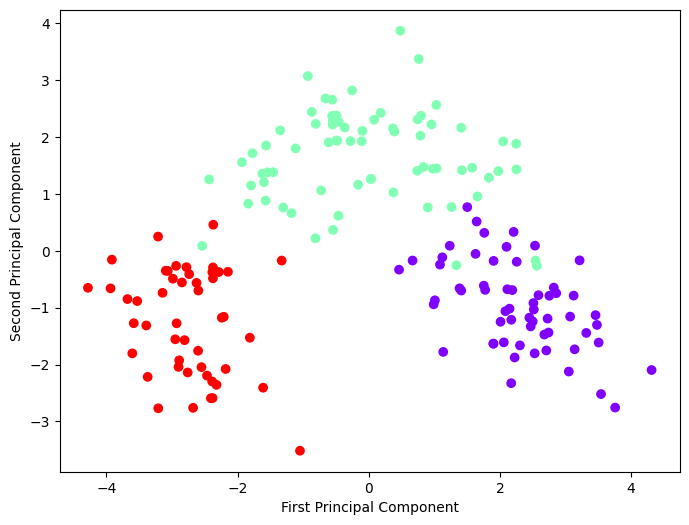

[0.36198848 0.1920749 ]


In [160]:
# The following code was adapted from a tutorial at https://scicoding.com/how-to-use-scikit-learn-for-principal-component-analysis-pca/
# This code block used the wine dataset of the sklearn.datasets library to demonstrate how to use sklearn PCA tools. 
# Our mission is to use the following framework to extract meaningful PCA findings from the n=10,000 sample training set and display the findings 
# graphically as shown in the example.

# BEGIN EXAMPLE OF PCA WITH VISUAL AID
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine

data = load_wine()  # example
# print(type(data))

# # Assign the outcome variable 'y' and the list of predictive attributes we want to examine using PCA.
X = data.data  # example
y = data.target  # example
print("Determine the dtype of X and y from the example:")
print()
print("X is of dtype:", type(X))  # X is stored as a 'numpy.ndarray' object with a dataframe decomposed into normalized row vectors. (we must match this structure AND the X & y label assignments to use this framework of tools.)
print()
print("value of X:") 
print(X)
print()
print("y is of dtype:", type(y[0]))
print()
print("value of y:") 
print(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()
print(pca.explained_variance_ratio_)



# BEGIN our code:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Below are our equivalent variables for PCA (WE NEED TO FIND OUT HOW TO APPLY THESE LABELS TO THE DATAFRAME AT THE RIGHT TIME.)
# scaler = StandardScaler()  # still active (from above)
# D =  collisions_n_10000_training_set_df[numeric_collision_columns] # Primary dataframe under consideration. Decide what dataframe (representing a table) that you want to analyze and place it here.

# X = np.asarray([np.asarray(D['motorcycle_collision']),np.asarray(D['intersection']),np.asarray(D['alcohol_involved'])])  # Convert a section of the training set into a feature vector 'X'
# X = scaler.fit_transform(X)
# y = np.asarray(victims_matching_10000_training_df['victim_ejected'])  # Define an attribute that we would like to observe here (note that outcome 'y' is assumed to be controlled/determined by feature vector X)
# y = y.target()

# # TODO: Once we have selected an outcome attribute, we need to replace the outcomes of the dataframe with integer labels that work with the plot generator above. 
# for i in range(len(y)):
#     if y[i] == 'ejected':
#         y[i] = 0
#         y[i] = y[i].astype(np.int32)
#     if y[i] == 'not ejected':
#         y[i] = 1
#         y[i] = y[i].astype(np.int32)
#     if y[i] == 'unknown':
#         y[i] = 2
#         y[i] = y[i].astype(np.int32)
#     if y[i] == 'partially ejected':
#         y[i] = 3
#         y[i] = y[i].astype(np.int32)

# print()
# print("value of X (our model):") 
# print(X)  # check to see if X is in a form matching the sample above.
# print()
# print("value of y (our model):") 
# print(type(y))  # check to see if y is in a form matching the sample above.


# X = scaler.fit_transform(X)
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# plt.figure(figsize=(8,6))
# plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='rainbow')
# plt.xlabel('First Principal Component')
# plt.ylabel('Second Principal Component')
# plt.show()

# data_1 = collisions_n_10000_training_set_df[numeric_collision_columns]   # substitute with our data.
# Assign the 'X' feature vector to the data frame here before converting it to a 'numpy.ndarray'. (composed of several attribute columns)
# Assign'y' the outcome variable to the data frame here before converting it to a 'numpy.ndarray'. (composed of one attribute column we are interested in observing)
# scaler.fit_transform(data_1)
# X = data_1.to_numpy()  # convert t

# print(type(data_1))
# print(data_1)

### I am still unsure if the following sklearn decomposition can be used for PCA. 

In [161]:
import numpy as np
from sklearn import decomposition
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# USE THE NORMALIZED TRAINING SETS TO PERFORM NUMERICAL PCA. 
# This pca.fit_transform() function is used for linear dimensionality reduction using SVD, which stands for "Scalar Value Decomposition". 
# We can use PCA to gain a perspective of the correlation between numeric attributes in the sample data set.

pca = decomposition.PCA(n_components=5)  # Produce a PCA analysis with the specified number of attributes
X_std_pca = pca.fit_transform(X_std)  # feed the standard vector transformation to the PCA motor
X_min_max_pca = pca.fit_transform(X_min_max)  # do the same thing for the min-max normalization, so we can compare them.

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print("BEGIN standard normalized vector decomposition numeric PCA...")
print("Dimensions of the numeric attribute columns before standard normalized vector decomposition PCA:", collisions_n_10000_training_set_df[numeric_collision_columns].shape)
print("Number of relevant numeric attribute columns, as identified by standard normalized vector decomposition PCA:", X_std_pca.shape)
print()
print(X_std_pca)
print("END standard normalized vector decomposition numeric PCA")
print()
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print()
print("BEGIN min-max normalized vector decomposition numeric PCA...")
print("Number of relevant numeric attribute columns, as identified by min-max normalized vector decomposition PCA:", X_std_pca.shape)
print()
print(X_min_max_pca)
print()
print("END min-max normalized vector decomposition numeric PCA")
print()
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')


# X = collisions_n_10000_training_set_df[numeric_collision_columns]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
BEGIN standard normalized vector decomposition numeric PCA...
Dimensions of the numeric attribute columns before standard normalized vector decomposition PCA: (10000, 23)
Number of relevant numeric attribute columns, as identified by standard normalized vector decomposition PCA: (10000, 5)

[[ 2.25550121  0.28173795  0.71087445 -1.4663565  -2.06809572]
 [ 0.08641235 -0.88321236  0.07507576 -1.06206976  0.37550163]
 [ 1.00588148 -0.20131109  0.45848718 -1.14452745 -0.94349356]
 ...
 [-0.41459439 -1.12543577  0.18833159 -0.35442556  0.56016482]
 [ 2.9433025   3.78030673 -0.06831969  0.51572803 -4.02450648]
 [-1.91593601  0.52798947  0.00430571  1.31507468 -0.44465777]]
END standard normalized vector decomposition numeric PCA

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

BEGIN min-max normalize

ValueError: could not convert string to float: '>250000'

In [ ]:
# EXPERIMENTAL CODE SECTION (KEEP FOR NOW)

# import matplotlib.pyplot as plt
# from sklearn.datasets import make_moons
 
# X, y =   collisions_n_10000_training_set_df[numeric_collision_columns], collisions_n_10000_training_set_df[numeric_collision_columns] # assign two numeric columns
 
# X = collisions_n_10000_training_set_df[numeric_collision_columns[7]]
# y = collisions_n_10000_training_set_df[numeric_collision_columns[7]]

# plt.show()

# print(numeric_collision_columns[0])

# from sklearn.decomposition import PCA
# pca = PCA(n_components=23)  # select the number of principal components to investigate

# USE THIS CODE TO APPLY THE TRANSFORMATION TO THE DATA FRAME (DO NOT DELETE, CONTROLS NORMALIZATION OF THE DATA FRAME FED TO PCA)
# collisions_n_10000_training_set_df[numeric_collision_columns] = min_max_scaler.fit_transform(collisions_n_10000_training_set_df[numeric_collision_columns])
# collisions_n_10000_training_set_df[numeric_collision_columns] = std_scalar.fit_transform(collisions_n_10000_training_set_df[numeric_collision_columns])

# X_pca = pca.fit_transform(collisions_n_10000_training_set_df[numeric_collision_columns]  # Perform PCA "as-is"
# X_pca = pca.fit_transform(std_scalar.fit_transform(collisions_n_10000_training_set_df[numeric_collision_columns]))  # apply standard (z-score) transform
# X_pca = pca.fit_transform(min_max_scaler.fit_transform(collisions_n_10000_training_set_df[numeric_collision_columns]))  # apply min_max transform
 
# WARNING: This code will generate a LOT of graphs! 
# generate a bunch of plots to see if any of the attributes are correlated or demonstrate any interesting patterns.
# for i in range(23):
#     for j in range(23):
#         if i != j: 
#             title = "PCA:" + "'" + numeric_collision_columns[i] + "'" + " vs. " + "'" + numeric_collision_columns[j] + "'"
#             plt.title(title)
#             plt.scatter(X_pca[:, i], X_pca[:, j], c=y, cmap='plasma')  # change the values at these index definitions to control which variables are compared.
#             plt.xlabel(numeric_collision_columns[i])  # replace these labels with the column name
#             plt.ylabel(numeric_collision_columns[j])
#             plt.show()
            
# X_pca.components_

Here we find all the numeric and discrete attributes in the collisions table, so we can more easily see which should be included in specific tests, or normalized.

In [84]:
# Using your dataframe 'collisions_random_10000_df'
numeric_cols = collisions_random_10000_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = collisions_random_10000_df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns: ", numeric_cols)
print("Categorical columns: ", categorical_cols)

Numeric columns:  ['jurisdiction', 'distance', 'intersection', 'state_highway_indicator', 'caltrans_district', 'state_route', 'postmile', 'tow_away', 'killed_victims', 'injured_victims', 'party_count', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 'truck_collision', 'not_private_property', 'alcohol_involved', 'severe_injury_count', 'other_visible_injury_count', 'complaint_of_pain_injury_count', 'pedestrian_killed_count', 'pedestrian_injured_count', 'bicyclist_killed_count', 'bicyclist_injured_count', 'motorcyclist_killed_count', 'motorcyclist_injured_count', 'latitude', 'longitude']
Categorical columns:  ['case_id', 'reporting_district', 'population', 'county_city_location', 'county_location', 'chp_beat_type', 'primary_road', 'secondary_road', 'direction', 'weather_1', 'weather_2', 'caltrans_county', 'route_suffix', 'postmile_prefix', 'location_type', 'ramp_intersection', 'side_of_highway', 'collision_severity', 'primary_collision_factor', 'pcf_violation_code', '

Below, we will create a DataFrame containing attributes that are most intuitively associated with collisions. We can also print out a row to see what the data looks like.

In [83]:
collisions_important_df = collisions_random_10000_df[['intersection', 'state_highway_indicator', 'killed_victims', 
    'injured_victims', 'party_count', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 
    'truck_collision', 'alcohol_involved', 'population', 'weather_1', 'location_type', 'collision_severity', 
    'primary_collision_factor', 'type_of_collision', 'pedestrian_action', 'road_surface', 'road_condition_1', 
    'lighting', 'control_device']]

collisions_important_df['alcohol_involved'] = collisions_important_df['alcohol_involved'].fillna(0) # Filling in 0 for NaN values in alcohol involvement so they can be used in calculations.

print(collisions_important_df.head(1)) # Print one row of the table so we can see what it looks like

   intersection  state_highway_indicator  killed_victims  injured_victims  \
0           1.0                      1.0             0.0              0.0   

   party_count  pedestrian_collision  bicycle_collision  motorcycle_collision  \
0            2                     0                  0                     0   

   truck_collision  alcohol_involved  ... weather_1 location_type  \
0                0               0.0  ...     clear          ramp   

     collision_severity primary_collision_factor type_of_collision  \
0  property damage only   vehicle code violation         sideswipe   

        pedestrian_action road_surface road_condition_1  \
0  no pedestrian involved          dry           normal   

                  lighting control_device  
0  dark with street lights    functioning  

[1 rows x 21 columns]


C:\Users\jmica\AppData\Local\Temp\ipykernel_27400\3099857728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collisions_important_df['alcohol_involved'] = collisions_important_df['alcohol_involved'].fillna(0) # Filling in 0 for NaN values in alcohol involvement so they can be used in calculations.


## Some Visualizations

Lets make some histograms showing the involvement frequencies of driving condition factors.

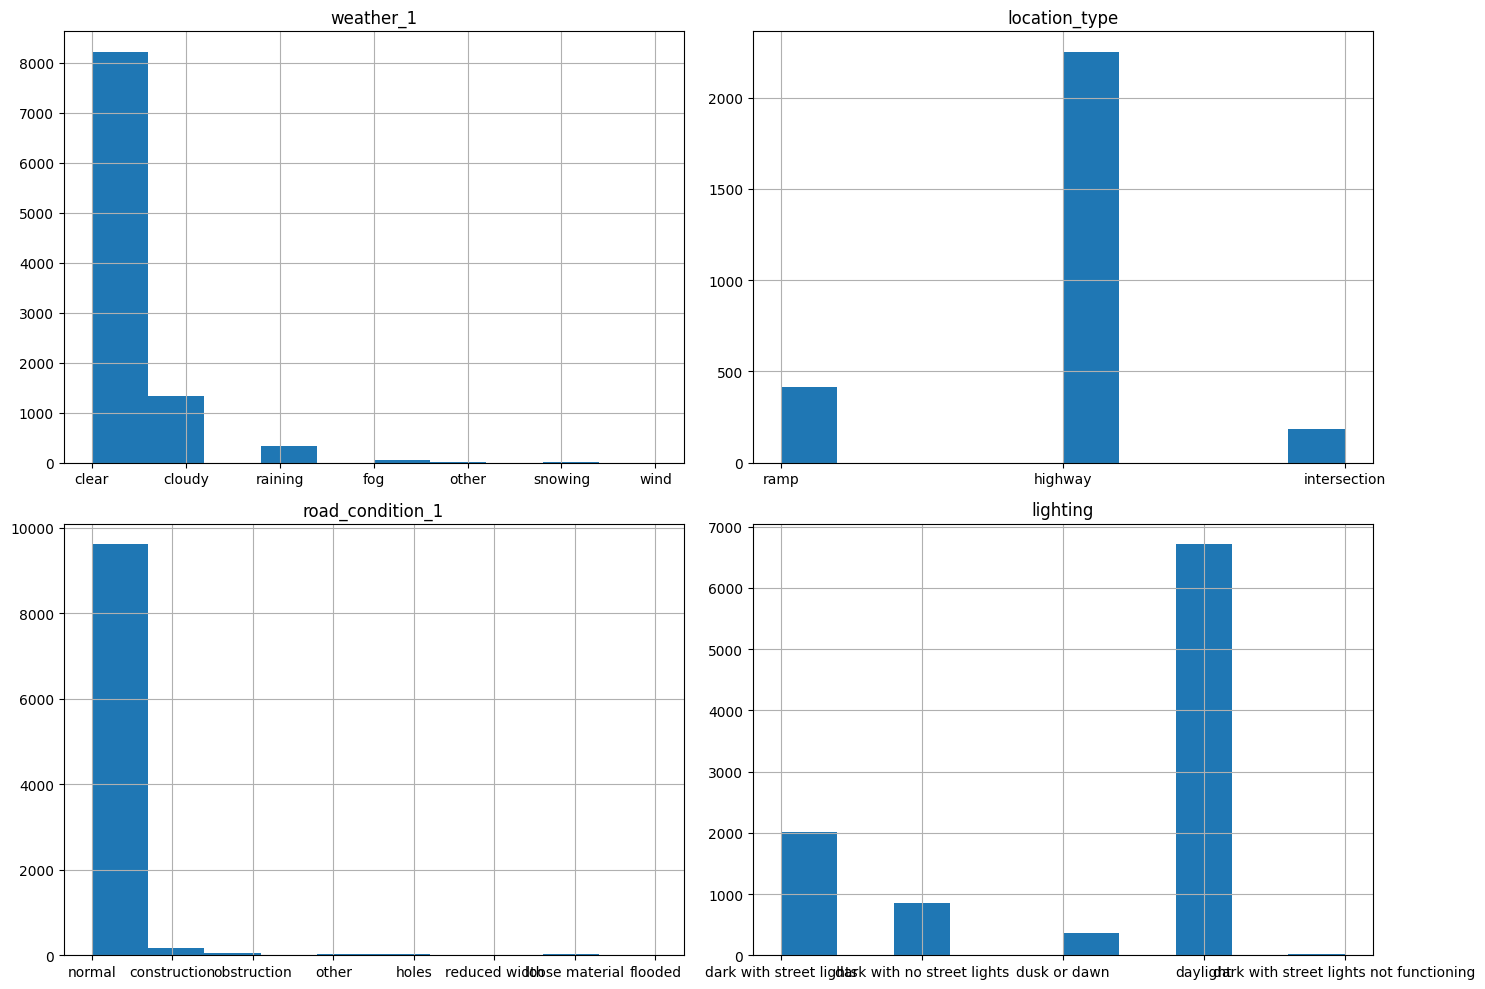

In [85]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
collisions_important_df['weather_1'].hist()
plt.title('weather_1')

plt.subplot(2, 2, 2)
collisions_important_df['location_type'].hist()
plt.title('location_type')

plt.subplot(2, 2, 3)
collisions_important_df['road_condition_1'].hist()
plt.title('road_condition_1')

plt.subplot(2, 2, 4)
collisions_important_df['lighting'].hist()
plt.title('lighting')

plt.tight_layout()
plt.show()

Now we should take a look at frequencies of human behaviors that contribute to accidents.

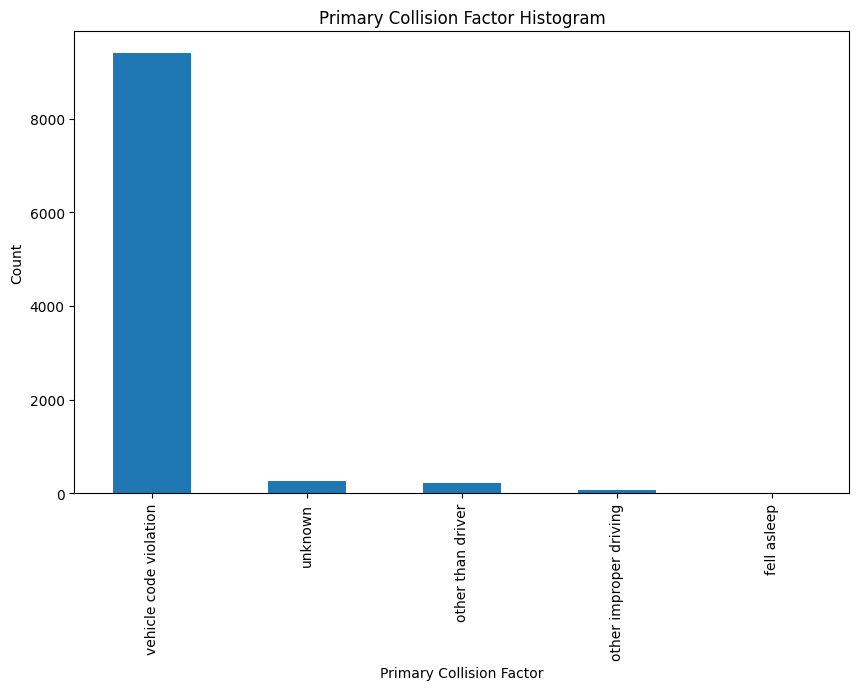

In [18]:
plt.figure(figsize=(10, 6))  # Set the figure size
collisions_important_df['primary_collision_factor'].value_counts().plot(kind='bar')
plt.title('Primary Collision Factor Histogram')  # Set the title
plt.xlabel('Primary Collision Factor')  # Set x-axis label
plt.ylabel('Count')  # Set y-axis label
plt.show()

Below we form a correlation matrix for the numeric attributes of the collisions table. This will help us visualize the relationships that attributes have with each other.

In [19]:
numeric_cols_df = collisions_important_df.select_dtypes(include=[np.number])
# Using your dataframe 'collisions_random_10000_df'
correlation_matrix = numeric_cols_df.corr()

# Printing correlation matrix
print(correlation_matrix)

                         intersection  state_highway_indicator  \
intersection                 1.000000                -0.283647   
state_highway_indicator     -0.283647                 1.000000   
killed_victims              -0.012528                 0.008124   
injured_victims              0.130725                -0.044783   
party_count                  0.041859                 0.012284   
pedestrian_collision         0.048578                -0.102581   
bicycle_collision            0.072667                -0.092591   
motorcycle_collision        -0.008799                 0.020541   
truck_collision             -0.059831                 0.134607   
alcohol_involved            -0.042708                -0.056140   

                         killed_victims  injured_victims  party_count  \
intersection                  -0.012528         0.130725     0.041859   
state_highway_indicator        0.008124        -0.044783     0.012284   
killed_victims                 1.000000         0.0596

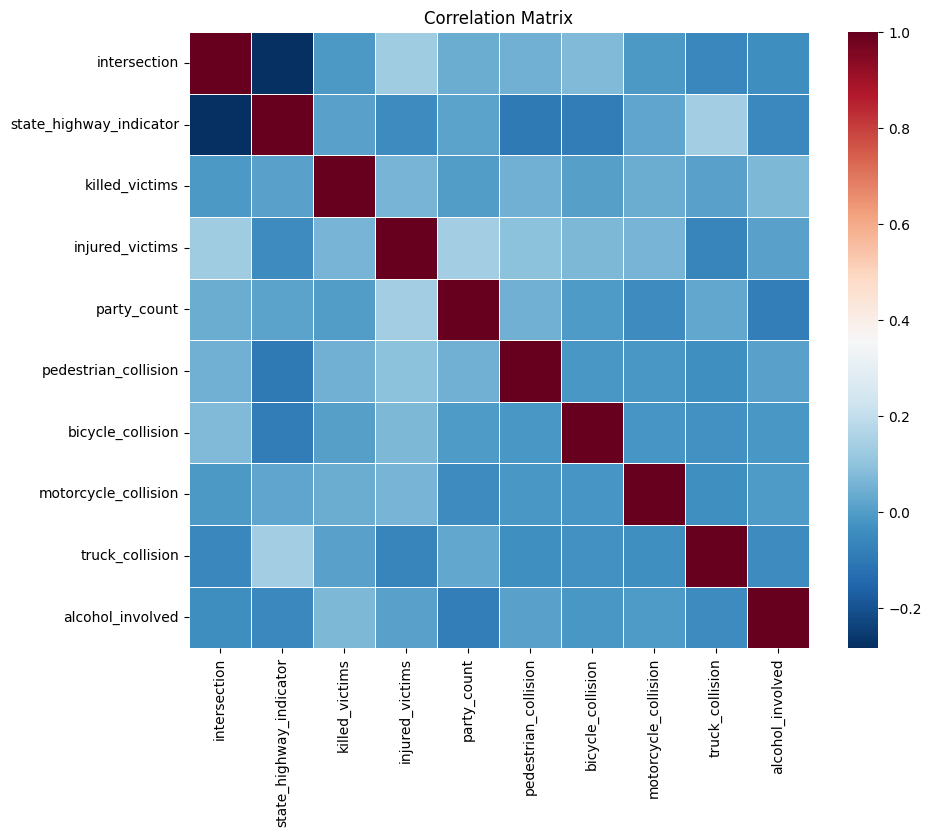

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Optional: You can set the figure size

sns.heatmap(correlation_matrix, 
            xticklabels=correlation_matrix.columns, 
            yticklabels=correlation_matrix.columns, 
            cmap='RdBu_r', 
            annot=False, 
            linewidth=0.5)

plt.title('Correlation Matrix')
plt.show()

#### Parties Table

In [8]:
# RANDOM SAMPLER STUB FOR 'parties' table
# Read 10000 randomly selected sqlite table query tuples into a local pandas DataFrame
parties_random_10000_df = pd.read_sql_query("SELECT * FROM parties ORDER BY RANDOM() LIMIT 10000;", sqliteConnection)
print(parties_random_10000_df.head())

        id  case_id  party_number      party_type  at_fault party_sex  \
0   160569  3653987             2  parked vehicle         0      None   
1  5746405  3074257             2          driver         0      male   
2  6469431  8507295             1          driver         1      male   
3  4945871  2659636             1          driver         1      male   
4  5458574  7158867             1          driver         1      male   

   party_age         party_sobriety party_drug_physical direction_of_travel  \
0        NaN         not applicable      not applicable               south   
1       51.0  had not been drinking                None                west   
2       44.0  had not been drinking                None                east   
3       29.0  had not been drinking                None                west   
4       18.0  had not been drinking                None                east   

   ... other_associate_factor_2 party_number_killed party_number_injured  \
0  ...    

#### Victims Table

In [10]:
# RANDOM SAMPLER STUB FOR 'victims' table
# Read 10000 randomly selected sqlite table query tuples into a local pandas DataFrame
victims_random_10000_df = pd.read_sql_query("SELECT * FROM victims ORDER BY RANDOM() LIMIT 10000;", sqliteConnection)
print(victims_random_10000_df.head())

        id              case_id  party_number victim_role victim_sex  \
0  1367181              1339627             2      driver       male   
1  1988026              6151672             2   passenger       male   
2  1284666              1255492             2   passenger     female   
3  8667800  9525011104100016575             2   passenger     female   
4  4993188              9165698             3      driver       male   

   victim_age victim_degree_of_injury victim_seating_position  \
0        53.0       complaint of pain                  driver   
1        88.0               no injury        passenger seat 6   
2         8.0               no injury        passenger seat 6   
3        59.0       complaint of pain        passenger seat 5   
4        28.0       complaint of pain                  driver   

   victim_safety_equipment_1  victim_safety_equipment_2 victim_ejected  
0       air bag not deployed  lap/shoulder harness used    not ejected  
1               not required  

In [36]:
# # Create a view using SQLite so that we can access all data as if it were a single data point object.
# # Since collisions, parties, and victims contain all of the information we need, we would like to join these three tables to create our random samples.
# create_sql_view = """ 
#                     SELECT * 
#                     FROM collisions
#                     INNER JOIN parties ON collisions.case_id = parties.case_id
#                     INNER JOIN victims ON parties.case_id = victims.case_id AND parties.party_number = victims.party_number
#                     ORDER BY RANDOM() 
#                     LIMIT 100;
#                 """ 
# cursor.execute(create_sql_view)
# result = cursor.fetchall()


OperationalError: database or disk is full

In [ ]:
print(result)

[]


In [ ]:
# This cell will defines a first round Data Cube Function(s)
create_data_cube = """SELECT 
    c1, c2, AGGREGATE_FUNCTION(c3)
FROM
    table_name
GROUP BY CUBE(c1 , c2);"""

### Not using stuff past this line

The functions below currently only work on csv files. Add a conditional behavior to these functions and extend them to extract equivalent data from a table in an SQLite db file. 

In [ ]:
# The following are basic statistic functions that can be used as helper routines in longer extraction/cleaning/clustering efforts. 
# The remainder of the notebook contains code written to examine the telescope data. You can to generalize each function or create a
# python scrip to examine tabular data files in a terminal window.

# There are many methods that you can use to extract SQLite table data into a pandas dataframe or a numpy data object to generate graphics, 
# or perform package-based statistical testing. At this point in the notebook (and as of 11-June-2023).

import pandas as pd
import numpy as np

# maximum value (max)
def maximum(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)  # read the file into a pandas dataframe
        column = MC_telescope_data.iloc[:,attribute_number]  # project the indicated column from the pandas dataframe
        result = column.max()  # find the maximum value
        return round(result, 2)

# minimum value (min)
def minimum(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        column = MC_telescope_data.iloc[:,attribute_number]
        result = column.min()  # find the minimum value
        return round(result, 2)

# average (mean)
def mean(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        column = MC_telescope_data.iloc[:,attribute_number]
        result = column.mean()  # calculate the average value
        return round(result, 2)

# standard deviation
def std(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        column = MC_telescope_data.iloc[:,attribute_number]
        result = column.std()  # calculate standard deviation
        return round(result, 2)

# first quantile, Q1
def q1(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        MC_telescope_df = pd.DataFrame(MC_telescope_data)
        column = MC_telescope_df.iloc[:,attribute_number]
        result = column.quantile([0.25]).values[0]
        return round(result, 2)

# third quantile, Q3
def q3(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        MC_telescope_df = pd.DataFrame(MC_telescope_data)
        column = MC_telescope_df.iloc[:,attribute_number]
        result = column.quantile([0.75]).values[0]
        return round(result, 2)

# median, Q2
def median(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        MC_telescope_df = pd.DataFrame(MC_telescope_data)
        column = MC_telescope_df.iloc[:,attribute_number]  # slice the indiced column
        result = column.quantile([0.5]).values[0]  # compute the second quantile
        return round(result, 2)

# inner-quartile range
def iqr(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        iqr = float(q3(filename, attribute_number))-float(q1(filename, attribute_number))
        # return "{:.2f}".format(iqr)  # format to 2 decimal places.
        return round(iqr, 2)

# N (number of objects)
def count(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        MC_telescope_df = pd.DataFrame(MC_telescope_data)
        column = MC_telescope_df.iloc[:,attribute_number]  # slice the indicated column
        result = column.count()  # count 
        return result

In [ ]:
# OUTPUT TESTING
print("N:", count("", 7))  # N
print("Q1:", q1("", 7))  # Q1
print("median:", median("", 7))  # Median (Q2)
print("Q3:", q3("", 7))  # Q3
print("IQR:", iqr("", 7))  # IQR
print("min:", minimum("", 7))  # min
print("max:", maximum("", 7))  # max
print("average:", mean("", 7))  # mean
print("std. deviation:", std("", 7))  # standard deviation

# # ERROR HANDLING
# print(maximum("magic04.data", 2.1))  # float (in-range)
# print(minimum("magic04.data", -1))  # out of bounds (less than)
# print(mean("magic04.data", 0))  # zero
# print(std("magic04.data", -1.5))  # negative out of range float
# print(q1("magic04.data", 10.5))  # positive out of range float
# print(median("magic04.data", 11))  # positive out of range (greater than)
# print(q3("magic04.data", -11.5))  # negative out of range float (less than)

FileNotFoundError: [Errno 2] No such file or directory: ''

Next create a scatter plot using the 4th and 5th attributes. 

https://realpython.com/visualizing-python-plt-scatter/

In [ ]:
import matplotlib.pyplot as plt

# attribute_names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
# Attribute Definitions
#     1.  fLength:  continuous  # major axis of ellipse [mm]
#     2.  fWidth:   continuous  # minor axis of ellipse [mm] 
#     3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
#     4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
#     5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
#     6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
#     7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
#     8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
#     9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
#    10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
#    11.  class:    g,h         # gamma (signal), hadron (background)

attribute_names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
MC_telescope_data = pd.read_csv("magic04.data", header=None)  # tabular file header is absent
MC_telescope_data.columns = attribute_names  # attach the column attribute labels
MC_telescope_df = pd.DataFrame(MC_telescope_data)  # create a pandas dataframe 


MC_telescope_data_column_4 = MC_telescope_df.iloc[:,4]  #  
MC_telescope_data_column_5 = MC_telescope_df.iloc[:,5]  # 

# KEEP THIS CODE FOR REFERENCE
# plt.plot(MC_telescope_data_column_4, MC_telescope_data_column_5, "o")  # use plt.plot, if you want it to be fast.
# plt.scatter(MC_telescope_data_column_4, MC_telescope_data_column_5)  # use plt.scatter, if you want more features.

plt.scatter(x=MC_telescope_data_column_4, y=MC_telescope_data_column_5)  # use plt.scatter, if you want to use more features.
plt.xlabel(attribute_names[3])  # 
plt.ylabel(attribute_names[4])  # 
plt.title("Scatter Plot of 4th and 5th Dimensions, MAGIC Telescope Data")
plt.savefig('scatter_plot_dimensions_4_5')
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
num_list = [13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25, 25, 25, 25, 30, 33, 33, 35, 35, 35, 35, 36, 40, 45, 46, 52, 70]
interval_list = {'1-5':136, '6-15':181, '16-20':178, '21-50':695, '51-80':245, '81-110':177}  # Age:Frequency


def lst_mean(lst):
    result = np.mean(lst)
    return round(result, 3)

def lst_median(lst):
    result = np.median(lst)
    return round(result, 3)

def lst_mode(lst):
    result = stats.mode(lst, keepdims=True)
    # return round(result, 3)
    return result

def lst_histogram(lst):
    a = np.array(lst)
    items = Counter(lst).keys()  # find the number of unique values in the set to set the bins
    fig, ax = plt.subplots(figsize =(5, 3))
    plt.hist(a, bins=range(np.min(lst)-5, np.max(lst)+5))

def lst_multimode(lst):
    res = []
    test_list1 = Counter(lst)
    temp = test_list1.most_common(1)[0][1]  # Extracts values of greatest frequency in the set.
    for ele in lst:
        if lst.count(ele) == temp:
            res.append(ele)
            res = list(set(res))
    # printing results
    return "Data modality = " + str(len(res)) + "; mode list = " + str(res)

def lst_midrange(lst):
    min = np.min(lst)
    max = np.max(lst)
    return round( ((min + max)/2.0), 3)

def lst_q1(lst):
    arr = np.array(lst)
    result = np.quantile(arr, 0.25)
    return round(result, 3)

def lst_q3(lst):
    arr = np.array(lst)
    result = np.quantile(arr, 0.75)
    return round(result, 3)

def cum_freq_list_from_inerval(dict):
    cumulative_freq = 0
    cumulative_freq_lst = []
    for itm in dict:
        cumulative_freq += dict[itm]  # collect the item frequency
        cumulative_freq_lst.append(cumulative_freq)
    n = cumulative_freq_lst[-1]
    return cumulative_freq_lst
    
def find_n_by_2(dict):
    cumulative_freq_lst = cum_freq_list_from_inerval(dict)
    n = cumulative_freq_lst[-1]
    n_by_2 = n/2
    return n_by_2

def find_median_bin(n_by_2, cumulative_freq_lst):
    for i in range(len(cumulative_freq_lst)):
        if n_by_2 <= cumulative_freq_lst[i]:
            return i  # returns the index of the bin the median data point belongs to. 
        
# def estimate_median(n_by_2, cumulative_freq_lst):
    

In [ ]:
# num_list = [13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25, 25, 25, 25, 30, 33, 33, 35, 35, 35, 35, 36, 40, 45, 46, 52, 70]
# interval_list = {'1-5':136, '6-15':181, '16-20':178, '21-50':695, '51-80':245, '81-110':177}  # Age:Frequency

# test the functions
print("Mean: ", lst_mean(num_list))
print("Q1: ", lst_q1(num_list))
print("Q2: ", lst_median(num_list))
print("Q3: ", lst_q3(num_list))
print(lst_multimode(num_list))
print("Midrange ((min+max)/2.0) : ", lst_midrange(num_list))

# print("The data set is bimodal, with modes 25, 35.")
print(lst_histogram(num_list))  # use this to determine the mode(s) and modality of the set. 

Mean:  29.963
Q1:  20.5
Q2:  25.0
Q3:  35.0
Data modality = 2; mode list = [25, 35]
Midrange ((min+max)/2.0) :  41.5


NameError: name 'plt' is not defined

In [ ]:
# Question #4 on Computing Statistics using a Frequency Distribution Table
# Estimated median = L + (L + ((n/2)-B)/G)*w
# L is the lower class boundary of the group containing the median
# n is the total number of values
# B is the cumulative frequency of the groups before the median group
# G is the frequency of the median group
# w is the group width

print("Cumm. frequency list:", cum_freq_list_from_inerval(interval_list))
print("n:", cum_freq_list_from_inerval(interval_list)[-1])
print("n/2:", find_n_by_2(interval_list))
print("Group Index:", find_median_bin(find_n_by_2(interval_list), cum_freq_list_from_inerval(interval_list)))
print("Median data point resides in age group: '21-50'")


Cumm. frequency list: [136, 317, 495, 1190, 1435, 1612]
n: 1612
n/2: 806.0
Group Index: 3
Median data point resides in age group: '21-50'
